In [1]:
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
def make_checkboard(num_samples):
    x2 = np.random.rand(num_samples,2)

    x2[(x2[:,0] // 0.25 + x2[:,1] // 0.25) %2 == 0,0] +=  0.25
    x2[x2 > 1.0] -= 1
    x2 -= [0.5,0.5]
    x2 *= 2
    return x2

def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data



In [4]:
# X1 = make_moons(5000)[0]
# swiss_roll = make_swiss_roll(5000)[0]
# X0 = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

# X0 = (X0-X0.mean(axis=0,keepdims=True))/X0.std(axis=0,keepdims=True)
# X1 = (X1-X1.mean(axis=0,keepdims=True))/X1.std(axis=0,keepdims=True)


sample_X0 = lambda x: np.random.randn(x,2)
sample_X0 = lambda x: make_moons(x,noise=0.05)[0] #make_checkboard
sample_X1 = make_checkboard

X0 = sample_X0(5000)
X1 = sample_X1(5000)

X0 = torch.from_numpy(X0).to(dtype=torch.float32,device=device)
X1 = torch.from_numpy(X1).to(dtype=torch.float32,device=device)

In [32]:
def rectified_interpolant(x0,x1,t):
    return (1-t)*x0 + t*x1


def independent_coupling(x0,x1,t,path_std):
    return (1-t)*x0 + t*x1 + torch.randn_like(x0)*path_std

def rectified_vector(xt,x0,x1,t):
    return x1-x0

In [33]:
def trigonometric_interpolant(x0,x1,t):
    return torch.cos(0.5*np.pi*t)*x0 + torch.sin(0.5*np.pi*t)*x1

def trigonometric_vector(xt,x0,x1,t):
    return 0.5*np.pi*(-torch.sin(0.5*np.pi*t)*x0 + torch.cos(0.5*np.pi*t)*x1)

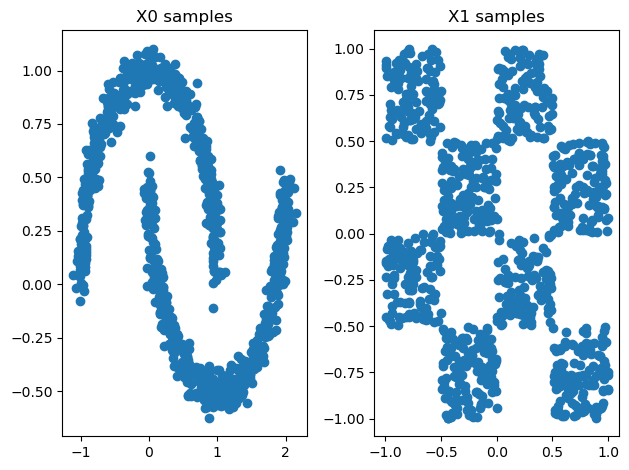

In [41]:
plt.subplot(1,2,1)
plt.scatter(X0[:1000,0].detach().cpu(),X0[:1000,1].detach().cpu())
plt.title("X0 samples")
plt.subplot(1,2,2)
plt.scatter(X1[:1000,0].detach().cpu(),X1[:1000,1].detach().cpu())
plt.title("X1 samples")
plt.tight_layout()

In [11]:
def get_encodings(x,num_freq): #encoding used in NeRF
    encoded = [x]
    for i in range(num_freq):
        encoded.append(torch.sin(2**i*torch.pi*x))
        encoded.append(torch.cos(2**i*torch.pi*x))
    return torch.cat(encoded,dim=-1)

def get_t_encodings(t,num_freqs):
    
    enc = torch.full((t.shape[0],num_freqs*2+1),2,dtype=torch.float32).to(device)
    p = torch.arange(num_freqs)[None,:].to(device)
    enc[:,1:num_freqs+1] = (enc[0,:num_freqs]**p)[:,None,:]*t*np.pi
    enc[:,num_freqs+1:] = enc[:,1:num_freqs+1]
    enc[:,1:num_freqs+1] = torch.sin(enc[:,1:num_freqs+1])
    enc[:,num_freqs+1:] = torch.cos(enc[:,num_freqs+1:])
    enc[:,0] = t[:,0]
    return enc

## Sinkhorn Entropic OT-solver

In [5]:
def sinkhorn_ot(a,b,M,reg=0.01,max_iter=100,eps=0.005,device=torch.device('cuda')):
    log_a = torch.log(a.flatten()).to(device)
    log_b = torch.log(b.flatten()).to(device)
    
    log_v = torch.zeros_like(b).to(device)
    prev_log_v = log_v.clone()
    
    log_K = -M / reg
    
    for i in range(max_iter):
        prev_log_v = log_v.clone()
        
        log_u = log_a - torch.logsumexp(log_K+log_v,1)
        log_v = log_b - torch.logsumexp(log_K.t()+log_u,1)
        
        if torch.abs(prev_log_v - log_v).mean() <eps:
            break
            
    return (log_u.unsqueeze(1) +log_K+log_v.unsqueeze(0)).exp()


In [185]:
num_hid_layers = 3
num_freq = 5
model = nn.Sequential(
        nn.Linear(2+num_freq*2+1,128),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(128, 128), nn.ReLU())],
        nn.Linear(128,2)
)   

model = model.to(device)

## Entropic OT flow matching

In [186]:
use_OT = True
with torch.no_grad():
    if use_OT:
        wass_pow = 2
        M = torch.cdist(X0,X1)**wass_pow
        a = torch.full((X0.shape[0],), 1/X0.shape[0])
        b = torch.full((X1.shape[0],), 1/X1.shape[0])

        T = sinkhorn_ot(a,b,M,reg=0.05,device=device)


In [188]:
print_every = 20
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
num_epoch = 1000
mb_size = 1024
loss_func = torch.nn.MSELoss()


interpolant = partial(independent_coupling,path_std=0.02)
cond_vec_field = rectified_vector
for e in range(num_epoch):
    if e%print_every == 0:
        acc_loss = 0
    for b in range(len(X0)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0),(mb_size,))
        x1_ind = torch.randint(0,len(X1),(mb_size,))
        
        if use_OT:
            x1_ind = torch.multinomial(T[x0_ind],1).flatten()

        x0 = X0[x0_ind]
        x1 = X1[x1_ind]

        rand_time = torch.rand((mb_size,1),device=device)
        enc_rand_time = get_t_encodings(rand_time,num_freq)
        xt = interpolant(x0,x1,rand_time) 

        cvf_target = cond_vec_field(xt,x0,x1,rand_time)
        vec_pred = model(torch.concat((xt,enc_rand_time),axis=1))

        optimizer.zero_grad()
        loss = loss_func(cvf_target.detach(),vec_pred)
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
    if e%print_every == 0:
        print(f"epoch:{e} loss: {acc_loss/(b*print_every)}")
    
    

epoch:0 loss: 0.0015430956380441784
epoch:20 loss: 0.001160265295766294
epoch:40 loss: 0.0011416631750762463
epoch:60 loss: 0.0012033474864438175
epoch:80 loss: 0.0011414353037253022
epoch:100 loss: 0.0011529739480465651
epoch:120 loss: 0.001121302228420973
epoch:140 loss: 0.0011163985822349788
epoch:160 loss: 0.001108040171675384
epoch:180 loss: 0.0012087938608601688
epoch:200 loss: 0.001184868160635233
epoch:220 loss: 0.0011047913925722242
epoch:240 loss: 0.0011650142027065159
epoch:260 loss: 0.00114407769870013
epoch:280 loss: 0.0011228978401049972
epoch:300 loss: 0.001167494314722717
epoch:320 loss: 0.0011270210845395923
epoch:340 loss: 0.0011268878355622292
epoch:360 loss: 0.0011491682613268494
epoch:380 loss: 0.0011623284546658397
epoch:400 loss: 0.0011642284225672483
epoch:420 loss: 0.001154764834791422
epoch:440 loss: 0.0011428246973082424
epoch:460 loss: 0.001188148674555123
epoch:480 loss: 0.0011415634537115694
epoch:500 loss: 0.0011468522483482958
epoch:520 loss: 0.001171007

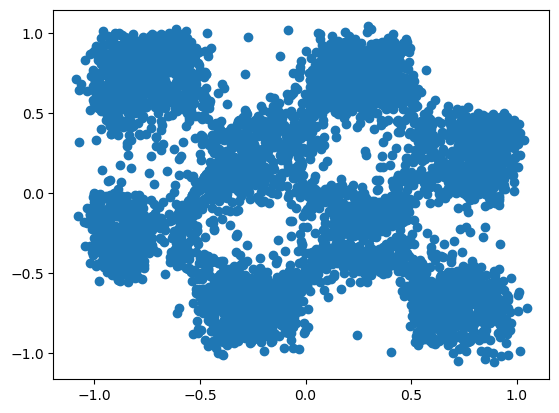

In [189]:
with torch.no_grad():
    num_time_steps = 10
    num_test_samples = 5000
    start_t = 0.0
    end_t = 1.0-start_t

    step_size = (end_t-start_t)/num_time_steps

#     X1_test = make_moons(num_test_samples)[0]
#     swiss_roll = make_swiss_roll(num_test_samples)[0]
#     X0_test = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

#     X0_test = (X0_test-X0_test.mean(axis=0,keepdims=True))/X0_test.std(axis=0,keepdims=True)
#     X1_test = (X1_test-X1_test.mean(axis=0,keepdims=True))/X1_test.std(axis=0,keepdims=True)

    X0_test = sample_X0(num_test_samples)
    X1_test = sample_X1(num_test_samples)

    X0_test = torch.from_numpy(X0_test).to(dtype=torch.float32,device=device)
    X1_test = torch.from_numpy(X1_test).to(dtype=torch.float32,device=device)

    if start_t == 1.0:
        xt_sample = X1_test[:num_test_samples].clone()
    elif start_t == 0.0:
        xt_sample = X0_test[:num_test_samples].clone()


    xts = []
    t = torch.full((len(xt_sample),1),start_t).to(device)
    for n in range(num_time_steps):
        xt_sample += step_size*model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
        t += step_size
        xts.append(xt_sample.detach().cpu().clone())
    plt.scatter(xt_sample[:,0].detach().cpu(),xt_sample[:,1].detach().cpu())

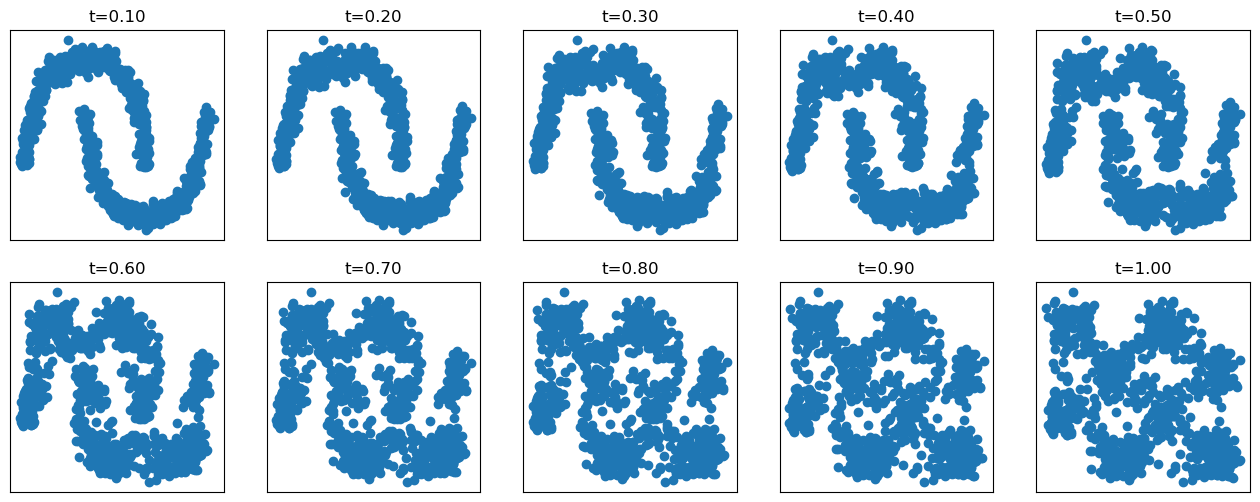

In [349]:
fig, axs = plt.subplots(2,5,figsize=(16,6))

for i in range(2):
    for j in range(5): 
        axs[i,j].scatter(xts[i*5+j][:1000,0].detach().cpu(),xts[i*5+j][:1000,1].detach().cpu())
        axs[i,j].set_title(f"t={(i*5+j)/10+0.1:.2f}")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])


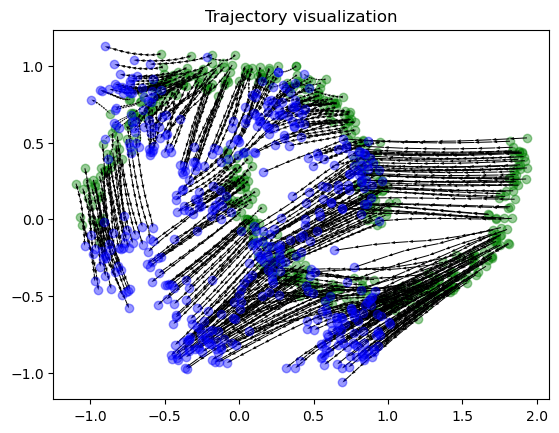

In [352]:
num_points = 500
for i in range(len(xts)):
    if i== 0:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='g',alpha=0.4)
    if i==len(xts)-1:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='b',alpha=0.4)
        continue
    plt.quiver(xts[i][:num_points,0],xts[i][:num_points,1],(xts[i+1]-xts[i])[:num_points,0],(xts[i+1]-xts[i])[:num_points,1],\
               scale=1,angles='xy',scale_units='xy',width=0.002)
    plt.title("Trajectory visualization")

## Schrödinger Bridges via Score and Flow Matching

In [179]:
def SB_cond_prob_path_mean(x0,x1,t):
    return ((1-t)*x0 + t*x1)

def SB_cond_prob_path_var(t,sigma):
    return sigma**2*t*(1-t)

def SB_vector_field(xt,x0,x1,t):
    return (1-2*t)/(t*(1-t)+1e-8)*(xt-((1-t)*x0 + t*x1)) + (x1-x0)


In [180]:
shared_model = False

num_hid_layers = 3
num_freq = 5
hid_dim = 256
vec_model = nn.Sequential(
        nn.Linear(2+num_freq*2+1,hid_dim),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(hid_dim, hid_dim), nn.ReLU())],
        nn.Linear(hid_dim,2)
)   

vec_model = vec_model.to(device)

num_hid_layers = 3
hid_dim = 256
score_model = nn.Sequential(
        nn.Linear(2+num_freq*2+1,hid_dim),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(hid_dim, hid_dim), nn.ReLU())],
        nn.Linear(hid_dim,2)
)   

score_model = score_model.to(device)

sigma = 0.5

with torch.no_grad():
    
    wass_pow = 2
    M = torch.cdist(X0,X1)**wass_pow
    a = torch.full((X0.shape[0],), 1/X0.shape[0])
    b = torch.full((X1.shape[0],), 1/X1.shape[0])

    T = sinkhorn_ot(a,b,M,reg=2*sigma,device=device)


In [181]:
print_every = 20
learning_rate = 1e-3
weight_decay=1e-5
optimizer1 = torch.optim.Adam(vec_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(score_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
num_epoch = 2000
mb_size = 1024
loss_func = torch.nn.MSELoss()


interpolant_mean = SB_cond_prob_path_mean
interpolant_var = partial(SB_cond_prob_path_var,sigma=sigma)

cond_vec_field = SB_vector_field

time_eps = 0.01

for e in range(num_epoch):
    if e%print_every == 0:
        acc_loss = 0
    for b in range(len(X0)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0),(mb_size,))
        x1_ind = torch.randint(0,len(X1),(mb_size,))
        
        if use_OT:
            x1_ind = torch.multinomial(T[x0_ind],1).flatten()

        x0 = X0[x0_ind]
        x1 = X1[x1_ind]

        rand_time = torch.rand((mb_size,1),device=device)
        rand_time = torch.clamp(rand_time,min=0+time_eps,max=1-time_eps)
        enc_rand_time = get_t_encodings(rand_time,num_freq)
        
        xt_mean = interpolant_mean(x0,x1,rand_time)
        
        eps_noise = torch.randn_like(x0)
        xt_var = interpolant_var(rand_time)
        
        xt = xt_mean+ eps_noise*torch.sqrt(xt_var)

        cvf_target = cond_vec_field(xt,x0,x1,rand_time)
        if shared_model:
            preds = vec_score_model(torch.concat((xt,enc_rand_time),axis=1))
            vec_preds = preds[:,:2]
            score_preds = preds[:,2:]
        else:
            vec_preds = vec_model(torch.concat((xt,enc_rand_time),axis=1))
            score_preds = score_model(torch.concat((xt,enc_rand_time),axis=1))
        
        score_target = -(xt - xt_mean)/xt_var
        

        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        loss1 = loss_func(cvf_target.detach(),vec_preds)
        loss2 = (xt_var.detach() * (score_target.detach()-score_preds)**2).mean()
        
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()
        acc_loss += loss2.item() + loss1.item()
    if e%print_every == 0:
        print(f"epoch:{e} loss: {acc_loss/(b*print_every)}")
    
    

epoch:0 loss: 0.20171839222311974
epoch:20 loss: 0.18265344500541686
epoch:40 loss: 0.1849266268312931
epoch:60 loss: 0.17049501091241837
epoch:80 loss: 0.17389171719551086
epoch:100 loss: 0.17350689843297004
epoch:120 loss: 0.16231118887662888
epoch:140 loss: 0.1613757334649563
epoch:160 loss: 0.16601465567946433
epoch:180 loss: 0.15288062766194344
epoch:200 loss: 0.15629687011241913
epoch:220 loss: 0.16367647871375085
epoch:240 loss: 0.15205679088830948
epoch:260 loss: 0.154563757032156
epoch:280 loss: 0.14951485246419907
epoch:300 loss: 0.14885445535182953
epoch:320 loss: 0.1510920248925686
epoch:340 loss: 0.1556684948503971
epoch:360 loss: 0.1554511807858944
epoch:380 loss: 0.1503164805471897
epoch:400 loss: 0.1493033342063427
epoch:420 loss: 0.15129854530096054
epoch:440 loss: 0.1504243403673172
epoch:460 loss: 0.1528100199997425
epoch:480 loss: 0.1450343571603298
epoch:500 loss: 0.15234346464276313
epoch:520 loss: 0.15610524788498878
epoch:540 loss: 0.16311826631426812
epoch:560 

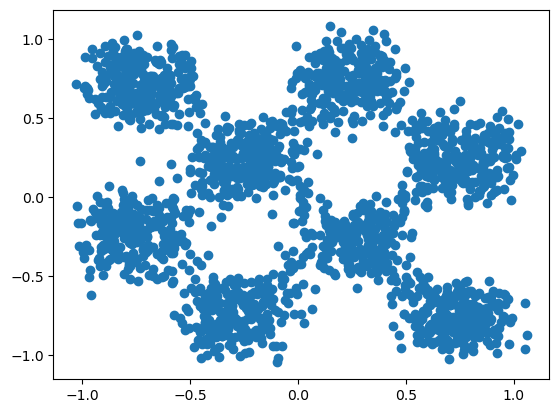

In [195]:
with torch.no_grad():
    num_time_steps = 100
    
    num_test_samples = 2000
    start_t = 0.0
    end_t = 1.0-start_t

    step_size = (end_t-start_t)/num_time_steps

    X0_test = sample_X0(num_test_samples)
    X1_test = sample_X1(num_test_samples)

    X0_test = torch.from_numpy(X0_test).to(dtype=torch.float32,device=device)
    X1_test = torch.from_numpy(X1_test).to(dtype=torch.float32,device=device)

    if start_t > 0.5:
        xt_sample = X1_test[:num_test_samples].clone()
    else:
        xt_sample = X0_test[:num_test_samples].clone()

    xts = []
    t = torch.full((len(xt_sample),1),start_t).to(device)
    for n in range(num_time_steps):
        
        drift_test = vec_model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
        score_test = score_model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
        if step_size<0:
            
            xt_sample += step_size*( drift_test-sigma**2*score_test/2) + np.sqrt(np.abs(step_size))*sigma*torch.randn_like(drift_test)
        else:
            xt_sample += step_size*(drift_test+sigma**2*score_test/2) + np.sqrt(np.abs(step_size))*sigma*torch.randn_like(drift_test)
        t += step_size
        xts.append(xt_sample.detach().cpu().clone())
        
        
    plt.scatter(xt_sample[:,0].detach().cpu(),xt_sample[:,1].detach().cpu())

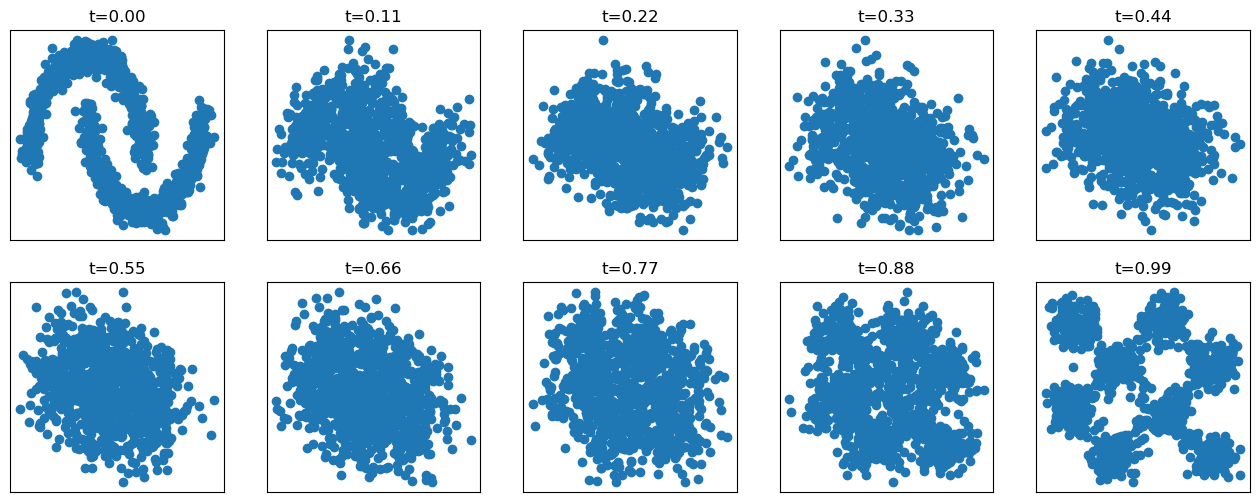

In [197]:
fig, axs = plt.subplots(2,5,figsize=(16,6))

i=j=0
for k in np.linspace(0,len(xts)-1,10):
    if j!=0 and j%5==0:
        i+=1
        j=0
    k = int(k)
    axs[i,j].scatter(xts[k][:1000,0].detach().cpu(),xts[k][:1000,1].detach().cpu())
    axs[i,j].set_title(f"t={abs(start_t-k/len(xts)):.2f}")
    
    
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    j+=1


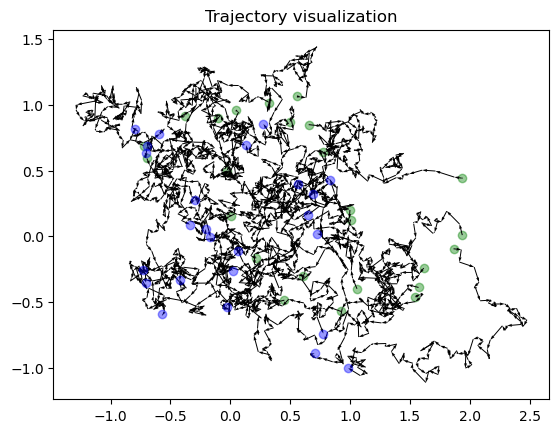

In [184]:
num_points = 25
for i in range(len(xts)):
    if i== 0:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='g',alpha=0.4)
    if i==len(xts)-1:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='b',alpha=0.4)
        continue
    plt.quiver(xts[i][:num_points,0],xts[i][:num_points,1],(xts[i+1]-xts[i])[:num_points,0],(xts[i+1]-xts[i])[:num_points,1],\
               scale=1,angles='xy',scale_units='xy',width=0.002)
    plt.title("Trajectory visualization")